In [1]:
import os
import time
import numpy as np 
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as K
from keras.utils import multi_gpu_model
import matplotlib.pyplot as plt
import scipy.io as sio
import h5py

Using TensorFlow backend.


#### Load Matlab Data
Original Images from IXI Dataest. Aliased images are synthesized with random k-space undersampling. 

In [2]:
I_orig1 = sio.loadmat('T2_orig_Large_part1.mat'); I_orig1 = I_orig1['T2_orig']
I_orig2 = sio.loadmat('T2_orig_Large_part2.mat'); I_orig2 = I_orig2['T2_orig']
I_orig3 = sio.loadmat('T2_orig_Large_part3.mat'); I_orig3 = I_orig3['T2_orig']
I_orig4 = sio.loadmat('T2_orig_Large_part4.mat'); I_orig4 = I_orig4['T2_orig']
I_orig = np.dstack( (I_orig1,I_orig2,I_orig3,I_orig4) ); I_orig = np.transpose(I_orig, axes = [2,0,1]);

I_aliased1 = sio.loadmat('T2_aliased_real_random2_Large_part1.mat'); I_aliased1 = I_aliased1['T2_aliased_real']
I_aliased2 = sio.loadmat('T2_aliased_real_random2_Large_part2.mat'); I_aliased2 = I_aliased2['T2_aliased_real']
I_aliased3 = sio.loadmat('T2_aliased_real_random2_Large_part3.mat'); I_aliased3 = I_aliased3['T2_aliased_real']
I_aliased4 = sio.loadmat('T2_aliased_real_random2_Large_part4.mat'); I_aliased4 = I_aliased4['T2_aliased_real']
I_aliased = np.dstack( (I_aliased1,I_aliased2,I_aliased3,I_aliased4) ); I_aliased = np.transpose(I_aliased, axes = [2,0,1]);

print(I_orig.shape)
print(I_aliased.shape)

(20000, 256, 256)
(20000, 256, 256)


#### Image Standardization 

In [4]:
Imax = np.max(I_orig)
Imin = np.min(I_orig)
I_orig = (I_orig-Imin)/(Imax-Imin)
I_aliased = (I_aliased-Imin)/(Imax-Imin)

#### Example of Aliased Image and Ground Truth Image

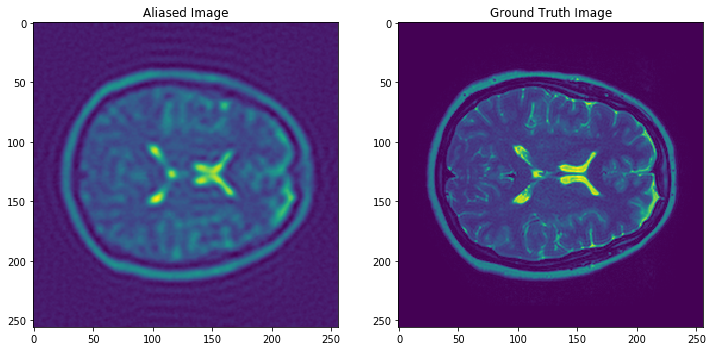

In [6]:
fig, ax1 = plt.subplots(1,2,figsize=(12,6))
ax1[0].imshow(I_aliased[70,:,:]); ax1[0].set_title('Aliased Image');
ax1[1].imshow(I_orig[70,:,:]); ax1[1].set_title('Ground Truth Image');

#### Train-Test Split

In [7]:
from sklearn.model_selection import train_test_split
I_orig = np.resize(I_orig,(I_orig.shape[0],256,256,1))
I_aliased = np.resize(I_aliased,(I_orig.shape[0],256,256,1))
x_train, x_test, y_train, y_test = train_test_split(I_aliased, I_orig, test_size=0.05, random_state=1)

print('training set x size:', np.shape(x_train))
print('dev set x size:', np.shape(x_test))

training set x size: (19000, 256, 256, 1)
dev set x size: (1000, 256, 256, 1)


### Unet Model

In [8]:
from Unet_2D import Unet_2D

Training set is split into training and validation set. Early stopping is used.

In [12]:
#pretrained_weights = ''
parallel_model = Unet_2D( pretrained_weights = None, input_size = (256,256,1) )

In [13]:
history = parallel_model.fit(x_train, y_train, validation_split = 0.05, epochs= 1, batch_size=32)

Train on 18050 samples, validate on 950 samples
Epoch 1/1
18050/18050 [==============================] - 246s 14ms/step - loss: 1.5124e-04 - val_loss: 1.5161e-04


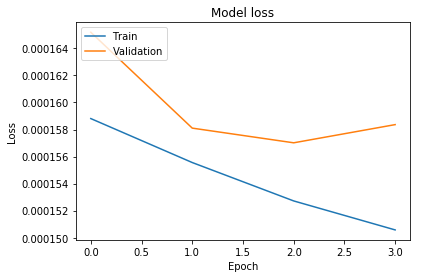

In [14]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [16]:
# loss and accuracy on the dev set
parallel_model.evaluate(x_test,y_test)

1000/1000 [==============================] - 9s 9ms/step


0.00015507098659873009

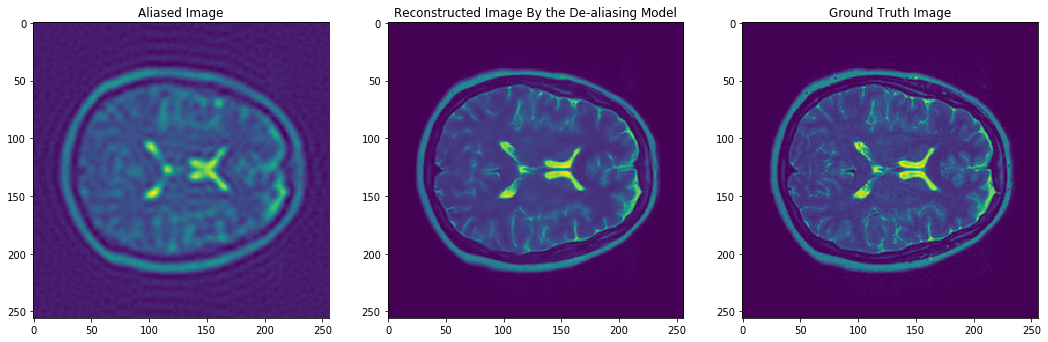

In [16]:
x_test0 = np.resize(I_aliased[70,:,:,0],(1,256,256,1))
y_test0 = I_orig[70,:,:,0]
y_predictions0 = parallel_model.predict( x_test0 )

fig2, ax2 = plt.subplots(1,3,figsize=(18,6))
ax2[0].imshow(x_test0[0,:,:,0]); ax2[0].set_title('Aliased Image');
ax2[1].imshow(y_predictions0[0,:,:,0]); ax2[1].set_title('Reconstructed Image By the De-aliasing Model');
ax2[2].imshow(y_test0); ax2[2].set_title('Ground Truth Image');

In [ ]:
#K.clear_session()